In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf
from collections import defaultdict

from evaluation import eval, eval_multi, logger, MODE_ADVERSARY, MODE_ADVERSARY_RANDOMIZE, MODE_RANDOM, MODE_ADV_TASK_DIVERSITY
plt.rcParams['text.usetex'] = False
%load_ext autoreload
%autoreload 2

In [5]:
T = 2000 # Timesteps/horizon
n_task = 6000
alpha_set = [1.0] # Bonus for UCB
v_set = [1.0] # Bonus for TS
alpha_PHE_set = [1.0] # Bonus for PHE
tau_1_PEGE_set = [T//2] # EXR length for PEGE
is_multi = True
input_dict = {
    "d":10, # n_dims
    "unit_ball_action": True,
    # "n_gen_context":20, #if not unit ball action set, how many action sampled from the action set
    "T":T, # Timesteps/horizon
    "n_sim":5, # Number of Simulations
    "rho":0.5,
    "noise_std":1,
    "seed":None, #TODO: bug here, must set to None
    "output":True,
    "params_set":alpha_set,
    "m":3, # n_dims latent
    "n_task":n_task,
    "mode":MODE_ADV_TASK_DIVERSITY,
    "adv_exr_const":0.1, # scaling factor for adversary task generation
    "adv_exr_task":None, # specific tasks to reveal a new dimension
    "PMA_exr_const":1.5, # scaling factor for exploration probability
    "PMA_lr_const":1, # scaling factor for the learning rate
    "PMA_n_expert":100000, # Expert set size for PMA
    "PMA_tau1_const":1, # scaling factor for PEGE's EXR length in the EXR phase
    "PMA_tau2_const":1, # scaling factor for PEGE's EXR length in the EXT phase
    "PMA_alpha_const":1, # scaling factor for PMA's alpha threshold
    "p_decay_rate":0, # decay rate for EXR prob. May be useful for Task Diversity setting
    "PMA_stop_exr":n_task, # Stop EXR after PMA_stop_exr step
    "PMA_no_oracle":False,
    "SeqRepL_exr_const":1.5,
    "SeqRepL_tau1_const":1,
    "SeqRepL_tau2_const":1,
    "SeqRepL_stop_exr":n_task, # Stop EXR after PMA_stop_exr step
    "fixed_params":[0.1, 400, 50], # fixed params for [p, tau1, tau2]
    "SeqRepL_exr_list": None
}

def get_SeqRepL_exr_list(n_task):
    SeqRepL_exr_list = []
    i=0
    while i**2 <= n_task:
        SeqRepL_exr_list.append(i**2)
        i+=1
    return SeqRepL_exr_list

def check_params():
    m = input_dict["m"]
    d = input_dict["d"]
    assert m<=d, "m >= d"
    assert m<=d, "m >= d"
    if T<d**2:
        logger.info(f"Warning: T < d**2")
    if n_task < np.sqrt(T):
        logger.info(f"Warning: n_task < np.sqrt(T)")
    if input_dict["adv_exr_task"] is not None:
        assert max(input_dict["adv_exr_task"]) < input_dict["n_task"], f"max exr task ({max(input_dict["adv_exr_task"])}) is larger than n_task ({input_dict["n_task"]})"
        assert len(input_dict["adv_exr_task"]) == input_dict["m"], f"exr list (len={len(input_dict["adv_exr_task"])}) is incorrect (!= m ({input_dict["m"]}))"

def load_dict(name):
    input_dict = np.load(name, allow_pickle='TRUE').item()
    input_dict = defaultdict(int,input_dict)
    mean_PEGE2 = input_dict['mean_PEGE2']
    std_PEGE2 = input_dict['std_PEGE2']
    mean_PEGE_oracle2 = input_dict['mean_PEGE_oracle2']
    std_PEGE_oracle2 = input_dict['std_PEGE_oracle2']
    mean_PMA2 = input_dict['mean_PMA2']
    std_PMA2 = input_dict['std_PMA2']
    mean_PMA_no_oracle2 = input_dict['mean_PMA_no_oracle2']
    std_PMA_no_oracle2 = input_dict['std_PMA_no_oracle2']
    mean_SeqRepL2 = input_dict['mean_SeqRepL2']
    std_SeqRepL2 = input_dict['std_SeqRepL2']
    return mean_PEGE2, std_PEGE2, mean_PEGE_oracle2, std_PEGE_oracle2, mean_PMA2, std_PMA2, mean_PMA_no_oracle2, std_PMA_no_oracle2, mean_SeqRepL2, std_SeqRepL2


# input_dict["fixed_params"] = None # fixed params for [p, tau1, tau2]
# input_dict["fixed_params"] = [0.1, 400, 50] # fixed params for [p, tau1, tau2]
input_dict["fixed_params"] = [0.15, 1000, 300] # fixed params for [p, tau1, tau2]

# With Task Diversity

In [129]:
check_params()

In [ ]:
input_dict["name"] = "PEGE"
input_dict["params_set"] = [190, 210] # tau_1
best_PEGE = eval_multi(input_dict)

In [ ]:
input_dict["name"] = "PEGE_oracle"
input_dict["params_set"] = [45, 55] # tau_2
best_PEGE_oracle = eval_multi(input_dict)

In [ ]:
input_dict["name"] = "PMA"
input_dict["params_set"] = [None] # Placeholder
input_dict["PMA_no_oracle"] = False
best_PMA = eval_multi(input_dict)

In [ ]:
input_dict["name"] = "PMA"
input_dict["PMA_no_oracle"] = True
best_PMA_no_oracle = eval_multi(input_dict)

In [ ]:
input_dict["name"] = "SeqRepL"
best_SeqRepL = eval_multi(input_dict)

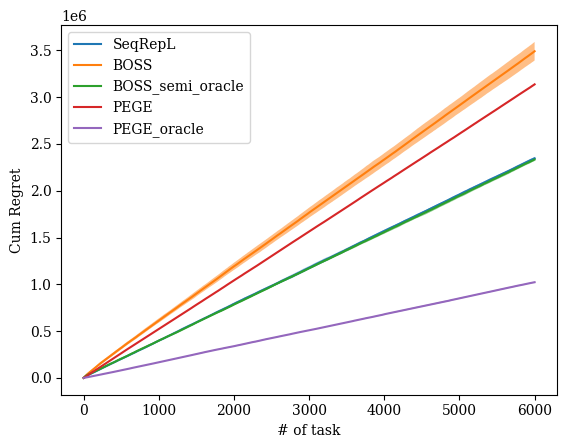

In [49]:
plot_prev_data = False
if plot_prev_data:
    mean_PEGE, std_PEGE, mean_PEGE_oracle, std_PEGE_oracle, mean_PMA, std_PMA, mean_PMA_no_oracle, std_PMA_no_oracle, mean_SeqRepL, std_SeqRepL = load_dict('TaskDiv_RegExp.npy')
else:
    mean_PEGE = np.mean(best_PEGE['regrets'], axis=0)
    std_PEGE = np.std(best_PEGE['regrets'], axis=0)
    mean_PEGE_oracle = np.mean(best_PEGE_oracle['regrets'], axis=0)
    std_PEGE_oracle = np.std(best_PEGE_oracle['regrets'], axis=0)
    mean_PMA = np.mean(best_PMA['regrets'], axis=0)
    std_PMA = np.std(best_PMA['regrets'], axis=0)
    mean_PMA_no_oracle = np.mean(best_PMA_no_oracle['regrets'], axis=0)
    std_PMA_no_oracle = np.std(best_PMA_no_oracle['regrets'], axis=0)
    mean_SeqRepL = np.mean(best_SeqRepL['regrets'], axis=0)
    std_SeqRepL = np.std(best_SeqRepL['regrets'], axis=0)
X = np.arange(1,n_task+1)
plt.plot(X, mean_SeqRepL, '-', label='SeqRepL')
plt.fill_between(X, mean_SeqRepL-std_SeqRepL, mean_SeqRepL+std_SeqRepL, alpha=0.5)
plt.plot(X, mean_PMA_no_oracle, '-', label='BOSS')
plt.fill_between(X, mean_PMA_no_oracle-std_PMA_no_oracle, mean_PMA_no_oracle+std_PMA_no_oracle, alpha=0.5)
plt.plot(X, mean_PMA, '-', label='BOSS_semi_oracle')
plt.fill_between(X, mean_PMA-std_PMA, mean_PMA+std_PMA, alpha=0.5)
plt.plot(X, mean_PEGE, '-', label='PEGE')
plt.fill_between(X, mean_PEGE-std_PEGE, mean_PEGE+std_PEGE, alpha=0.5)
plt.plot(X, mean_PEGE_oracle, '-', label='PEGE_oracle')
plt.fill_between(X, mean_PEGE_oracle-std_PEGE_oracle, mean_PEGE_oracle+std_PEGE_oracle, alpha=0.5)
plt.xlabel('# of task')
plt.ylabel('Cum Regret')
plt.legend()
plt.show()
# plt.close()
# output_dict = {
#     "mean_PEGE2":mean_PEGE,
#     "std_PEGE2":std_PEGE,
#     "mean_PEGE_oracle2":mean_PEGE_oracle,
#     "std_PEGE_oracle2":std_PEGE_oracle,
#     "mean_PMA2":mean_PMA,
#     "std_PMA2":std_PMA,
#     "mean_PMA_no_oracle2":mean_PMA_no_oracle,
#     "std_PMA_no_oracle2":std_PMA_no_oracle,
#     "mean_SeqRepL2":mean_SeqRepL,
#     "std_SeqRepL2":std_SeqRepL,
# }
# np.save('TaskDiv_RegExp.npy', output_dict) 

<>:17: SyntaxWarning: invalid escape sequence '\h'
<>:17: SyntaxWarning: invalid escape sequence '\h'
/var/folders/pq/3djhrh750zv53df3bfpn596r0000gn/T/ipykernel_88736/2781955303.py:17: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('||\hat(B)_{n, perp}^T B_n||_F')


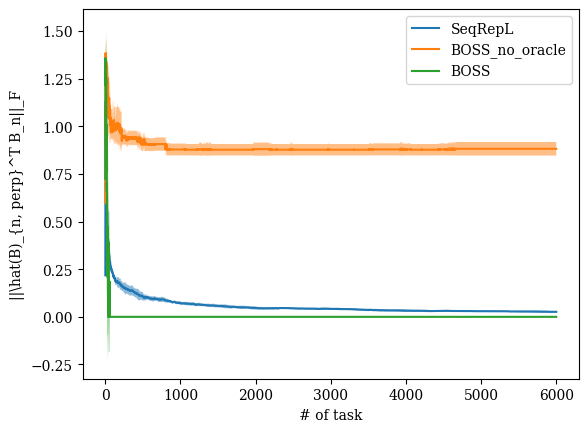

In [38]:
if plot_prev_data:
    mean_PEGE, std_PEGE, mean_PEGE_oracle, std_PEGE_oracle, mean_PMA, std_PMA, mean_PMA_no_oracle, std_PMA_no_oracle, mean_SeqRepL, std_SeqRepL = load_dict('TaskDiv_B.npy')
else:
    mean_PMA = np.mean(best_PMA['B_hat_err'], axis=0)
    std_PMA = np.std(best_PMA['B_hat_err'], axis=0)
    mean_SeqRepL = np.mean(best_SeqRepL['B_hat_err'], axis=0)
    std_SeqRepL = np.std(best_SeqRepL['B_hat_err'], axis=0)
    mean_PMA_no_oracle = np.mean(best_PMA_no_oracle['B_hat_err'], axis=0)
    std_PMA_no_oracle = np.std(best_PMA_no_oracle['B_hat_err'], axis=0)
plt.plot(X, mean_SeqRepL, '-', label='SeqRepL')
plt.fill_between(X, mean_SeqRepL-std_SeqRepL, mean_SeqRepL+std_SeqRepL, alpha=0.5)
plt.plot(X, mean_PMA_no_oracle, '-', label='BOSS_no_oracle')
plt.fill_between(X, mean_PMA_no_oracle-std_PMA_no_oracle, mean_PMA_no_oracle+std_PMA_no_oracle, alpha=0.5)
plt.plot(X, mean_PMA, '-', label='BOSS')
plt.fill_between(X, mean_PMA-std_PMA, mean_PMA+std_PMA, alpha=0.5)
plt.xlabel('# of task')
plt.ylabel('||\hat(B)_{n, perp}^T B_n||_F')
plt.legend()
plt.show()
# plt.close()
# output_dict = {
#     "mean_PMA2":mean_PMA,
#     "std_PMA2":std_PMA,
#     "mean_PMA_no_oracle2":mean_PMA_no_oracle,
#     "std_PMA_no_oracle2":std_PMA_no_oracle,
#     "mean_SeqRepL2":mean_SeqRepL,
#     "std_SeqRepL2":std_SeqRepL,
# }
# np.save('TaskDiv_B.npy', output_dict) 

<>:19: SyntaxWarning: invalid escape sequence '\h'
<>:19: SyntaxWarning: invalid escape sequence '\h'
/var/folders/pq/3djhrh750zv53df3bfpn596r0000gn/T/ipykernel_88736/2827546650.py:19: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('||\hat{theta}_n - theta_n||_2')


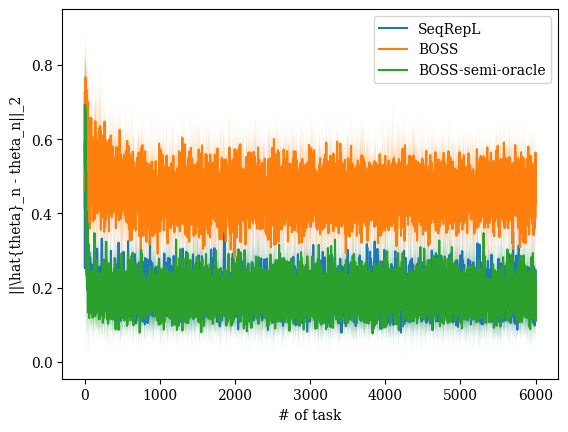

In [40]:
if plot_prev_data:
    mean_PEGE, std_PEGE, mean_PEGE_oracle, std_PEGE_oracle, mean_PMA, std_PMA, mean_PMA_no_oracle, std_PMA_no_oracle, mean_SeqRepL, std_SeqRepL = load_dict('TaskDiv_theta.npy')
else:
    mean_PMA = np.mean(best_PMA['theta_hat_err'], axis=0)
    std_PMA = np.std(best_PMA['theta_hat_err'], axis=0)
    mean_SeqRepL = np.mean(best_SeqRepL['theta_hat_err'], axis=0)
    std_SeqRepL = np.std(best_SeqRepL['theta_hat_err'], axis=0)
    mean_PMA_no_oracle = np.mean(best_PMA_no_oracle['theta_hat_err'], axis=0)
    std_PMA_no_oracle = np.std(best_PMA_no_oracle['theta_hat_err'], axis=0)

X = np.arange(1,n_task+1)
plt.plot(X, mean_SeqRepL, '-', label='SeqRepL')
plt.fill_between(X, mean_SeqRepL-std_SeqRepL, mean_SeqRepL+std_SeqRepL, alpha=0.5)
plt.plot(X, mean_PMA_no_oracle, '-', label='BOSS')
plt.fill_between(X, mean_PMA_no_oracle-std_PMA_no_oracle, mean_PMA_no_oracle+std_PMA_no_oracle, alpha=0.5)
plt.plot(X, mean_PMA, '-', label='BOSS-semi-oracle')
plt.fill_between(X, mean_PMA-std_PMA, mean_PMA+std_PMA, alpha=0.5)
plt.xlabel('# of task')
plt.ylabel('||\hat{theta}_n - theta_n||_2')
plt.legend()
plt.show()
# plt.close()
# output_dict = {
#     "mean_PMA2":mean_PMA,
#     "std_PMA2":std_PMA,
#     "mean_PMA_no_oracle2":mean_PMA_no_oracle,
#     "std_PMA_no_oracle2":std_PMA_no_oracle,
#     "mean_SeqRepL2":mean_SeqRepL,
#     "std_SeqRepL2":std_SeqRepL,
# }
# np.save('TaskDiv_theta.npy', output_dict) 

<>:15: SyntaxWarning: invalid escape sequence '\h'
<>:15: SyntaxWarning: invalid escape sequence '\h'
/var/folders/pq/3djhrh750zv53df3bfpn596r0000gn/T/ipykernel_88736/61379010.py:15: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('||\hat{theta}_n - theta_n||_2')


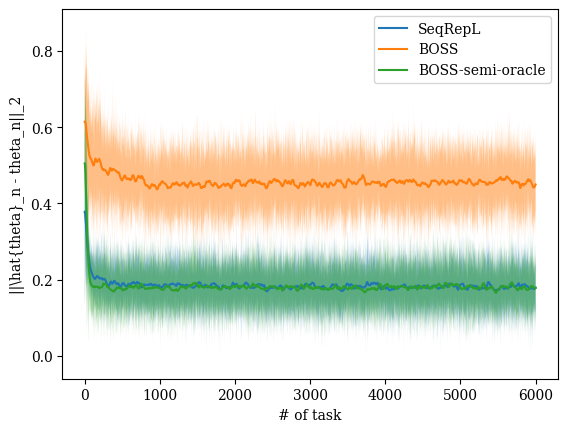

In [41]:
rbf = Rbf(X, mean_PMA_no_oracle, function = 'multiquadric', smooth = 500)
y_PMA_no_oracle_rbf = rbf(X)
rbf = Rbf(X, mean_PMA, function = 'multiquadric', smooth = 500)
y_PMA_rbf = rbf(X)
rbf = Rbf(X, mean_SeqRepL, function = 'multiquadric', smooth = 500)
y_SeqRepL_rbf = rbf(X)

plt.plot(X, y_SeqRepL_rbf, '-', label='SeqRepL')
plt.fill_between(X, y_SeqRepL_rbf-std_SeqRepL, y_SeqRepL_rbf+std_SeqRepL, alpha=0.5)
plt.plot(X, y_PMA_no_oracle_rbf, '-', label='BOSS')
plt.fill_between(X, y_PMA_no_oracle_rbf-std_PMA_no_oracle, y_PMA_no_oracle_rbf+std_PMA_no_oracle, alpha=0.5)
plt.plot(X, y_PMA_rbf, '-', label='BOSS-semi-oracle')
plt.fill_between(X, y_PMA_rbf-std_PMA, y_PMA_rbf+std_PMA, alpha=0.5)
plt.xlabel('# of task')
plt.ylabel('||\hat{theta}_n - theta_n||_2')

plt.legend()
plt.show()

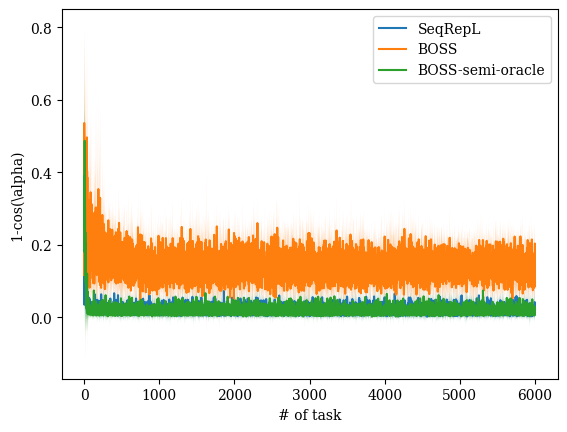

In [50]:
if plot_prev_data:
    mean_PEGE, std_PEGE, mean_PEGE_oracle, std_PEGE_oracle, mean_PMA, std_PMA, mean_PMA_no_oracle, std_PMA_no_oracle, mean_SeqRepL, std_SeqRepL = load_dict('TaskDiv_angle.npy')
else:
    mean_PMA = np.mean(best_PMA['angle_err'], axis=0)
    std_PMA = np.std(best_PMA['angle_err'], axis=0)
    mean_SeqRepL = np.mean(best_SeqRepL['angle_err'], axis=0)
    std_SeqRepL = np.std(best_SeqRepL['angle_err'], axis=0)
    mean_PMA_no_oracle = np.mean(best_PMA_no_oracle['angle_err'], axis=0)
    std_PMA_no_oracle = np.std(best_PMA_no_oracle['angle_err'], axis=0)

X = np.arange(1,n_task+1)
plt.plot(X, mean_SeqRepL, '-', label='SeqRepL')
plt.fill_between(X, mean_SeqRepL-std_SeqRepL, mean_SeqRepL+std_SeqRepL, alpha=0.5)
plt.plot(X, mean_PMA_no_oracle, '-', label='BOSS')
plt.fill_between(X, mean_PMA_no_oracle-std_PMA_no_oracle, mean_PMA_no_oracle+std_PMA_no_oracle, alpha=0.5)
plt.plot(X, mean_PMA, '-', label='BOSS-semi-oracle')
plt.fill_between(X, mean_PMA-std_PMA, mean_PMA+std_PMA, alpha=0.5)
plt.xlabel('# of task')
plt.ylabel('1-cos(\\alpha)')
plt.legend()
plt.show()
# plt.close()
# output_dict = {
#     "mean_PMA2":mean_PMA,
#     "std_PMA2":std_PMA,
#     "mean_PMA_no_oracle2":mean_PMA_no_oracle,
#     "std_PMA_no_oracle2":std_PMA_no_oracle,
#     "mean_SeqRepL2":mean_SeqRepL,
#     "std_SeqRepL2":std_SeqRepL,
# }
# np.save('TaskDiv_angle.npy', output_dict) 

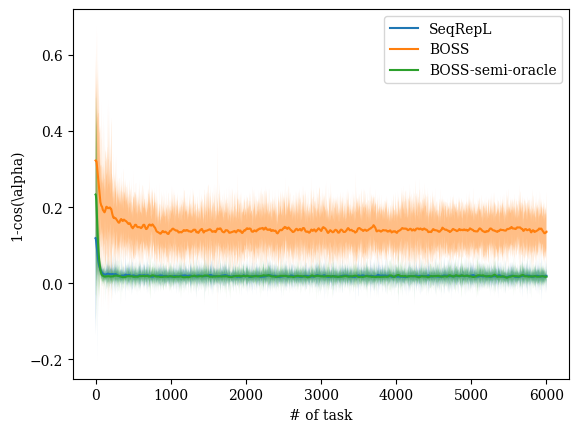

In [51]:
rbf = Rbf(X, mean_PMA_no_oracle, function = 'multiquadric', smooth = 500)
y_PMA_no_oracle_rbf = rbf(X)
rbf = Rbf(X, mean_PMA, function = 'multiquadric', smooth = 500)
y_PMA_rbf = rbf(X)
rbf = Rbf(X, mean_SeqRepL, function = 'multiquadric', smooth = 500)
y_SeqRepL_rbf = rbf(X)

plt.plot(X, y_SeqRepL_rbf, '-', label='SeqRepL')
plt.fill_between(X, y_SeqRepL_rbf-std_SeqRepL, y_SeqRepL_rbf+std_SeqRepL, alpha=0.5)
plt.plot(X, y_PMA_no_oracle_rbf, '-', label='BOSS')
plt.fill_between(X, y_PMA_no_oracle_rbf-std_PMA_no_oracle, y_PMA_no_oracle_rbf+std_PMA_no_oracle, alpha=0.5)
plt.plot(X, y_PMA_rbf, '-', label='BOSS-semi-oracle')
plt.fill_between(X, y_PMA_rbf-std_PMA, y_PMA_rbf+std_PMA, alpha=0.5)
plt.xlabel('# of task')
plt.ylabel('1-cos(\\alpha)')

plt.legend()
plt.show()

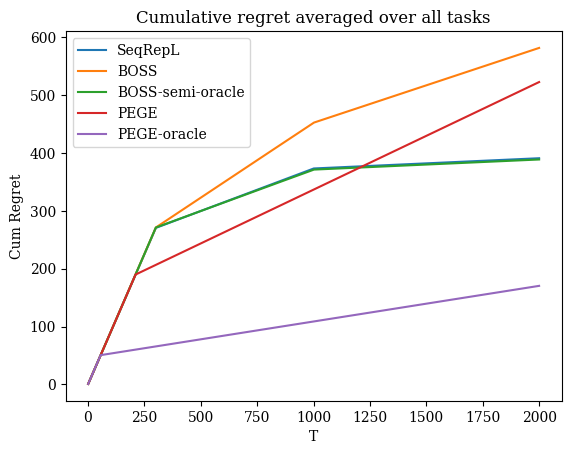

In [44]:
if plot_prev_data:
    mean_PEGE_in_T, std_PEGE_in_T, mean_PEGE_oracle_in_T, std_PEGE_oracle_in_T, mean_PMA_in_T, std_PMA_in_T, mean_PMA_no_oracle_in_T, std_PMA_no_oracle_in_T, mean_SeqRepL_in_T, std_SeqRepL_in_T = load_dict('TaskDiv_T.npy')
else:
    mean_PEGE_in_T = np.mean(best_PEGE['regrets_all'], axis=(0,-1))
    std_PEGE_in_T = np.std(best_PEGE['regrets_all'], axis=(0,-1))
    mean_PEGE_oracle_in_T = np.mean(best_PEGE_oracle['regrets_all'], axis=(0,-1))
    std_PEGE_oracle_in_T = np.std(best_PEGE_oracle['regrets_all'], axis=(0,-1))
    mean_PMA_in_T = np.mean(best_PMA['regrets_all'], axis=(0,-1))
    std_PMA_in_T = np.std(best_PMA['regrets_all'], axis=(0,-1))
    mean_PMA_no_oracle_in_T = np.mean(best_PMA_no_oracle['regrets_all'], axis=(0,-1))
    std_PMA_no_oracle_in_T = np.std(best_PMA_no_oracle['regrets_all'], axis=(0,-1))
    mean_SeqRepL_in_T = np.mean(best_SeqRepL['regrets_all'], axis=(0,-1))
    std_SeqRepL_in_T = np.std(best_SeqRepL['regrets_all'], axis=(0,-1))

X = np.arange(1,T+1)
plt.plot(X, mean_SeqRepL_in_T, '-', label='SeqRepL')
plt.plot(X, mean_PMA_no_oracle_in_T, '-', label='BOSS')
plt.plot(X, mean_PMA_in_T, '-', label='BOSS-semi-oracle')
plt.plot(X, mean_PEGE_in_T, '-', label='PEGE')
plt.plot(X, mean_PEGE_oracle_in_T, '-', label='PEGE-oracle')
# plt.fill_between(X, mean_SeqRepL_in_T-std_SeqRepL_in_T, mean_SeqRepL_in_T+std_SeqRepL_in_T, alpha=0.5)
# plt.fill_between(X, mean_PMA_no_oracle_in_T-std_PMA_no_oracle_in_T, mean_PMA_no_oracle_in_T+std_PMA_no_oracle_in_T, alpha=0.5)
# plt.fill_between(X, mean_PMA_in_T-std_PMA_in_T, mean_PMA_in_T+std_PMA_in_T, alpha=0.5)
# plt.fill_between(X, mean_PEGE_in_T-std_PEGE_in_T, mean_PEGE_in_T+std_PEGE_in_T, alpha=0.5)
# plt.fill_between(X, mean_PEGE_oracle_in_T-std_PEGE_oracle_in_T, mean_PEGE_oracle_in_T+std_PEGE_oracle_in_T, alpha=0.5)
plt.xlabel('T')
plt.ylabel('Cum Regret')
plt.legend()
plt.title(f'Cumulative regret averaged over all tasks')
plt.show()
# plt.close()
# output_dict = {
#     "mean_PEGE2":mean_PEGE_in_T,
#     "std_PEGE2":std_PEGE_in_T,
#     "mean_PEGE_oracle2":mean_PEGE_oracle_in_T,
#     "std_PEGE_oracle2":std_PEGE_oracle_in_T,
#     "mean_PMA2":mean_PMA_in_T,
#     "std_PMA2":std_PMA_in_T,
#     "mean_PMA_no_oracle2":mean_PMA_no_oracle_in_T,
#     "std_PMA_no_oracle2":std_PMA_no_oracle_in_T,
#     "mean_SeqRepL2":mean_SeqRepL_in_T,
#     "std_SeqRepL2":std_SeqRepL_in_T,
# }
# np.save('TaskDiv_T.npy', output_dict) 

# Without Task Diversity

In [374]:
input_dict["mode"] = MODE_ADVERSARY
input_dict["n_sim"] = 5
input_dict["adv_exr_task"] = [0, 500, 1000]
SeqRepL_exr_list = get_SeqRepL_exr_list(input_dict["n_task"])
input_dict["SeqRepL_exr_list"] = SeqRepL_exr_list

# input_dict["fixed_params"] = None # fixed params for [p, tau1, tau2]
input_dict["fixed_params"] = [5*len(SeqRepL_exr_list)/input_dict["n_task"], 1000, 300] # fixed params for [p, tau1, tau2]
check_params()

In [ ]:
input_dict["name"] = "PEGE"
input_dict["params_set"] = [190, 210] # tau_1
best_PEGE2 = eval_multi(input_dict)

In [ ]:
input_dict["name"] = "PEGE_oracle"
input_dict["params_set"] = [45, 55] # tau_1
best_PEGE_oracle2 = eval_multi(input_dict)

In [ ]:
input_dict["name"] = "PMA"

# input_dict["PMA_exr_const"] = 1 # 1.75
# input_dict["PMA_tau1_const"] = 2.5 #2.5
# input_dict["PMA_tau2_const"] = 0.8 #
# input_dict["PMA_alpha_const"] = 1.35 #1.35, 1.5
input_dict["PMA_no_oracle"] = False
best_PMA2 = eval_multi(input_dict)

In [ ]:
input_dict["name"] = "PMA"
input_dict["PMA_no_oracle"] = True
# input_dict["mode"] = MODE_ADVERSARY_RANDOMIZE
# input_dict["PMA_n_expert"] = 100000
# input_dict["PMA_exr_const"] = 1.3
# input_dict["PMA_tau1_const"] = 2.5
# input_dict["PMA_alpha_const"] = 1.4 #1.5

best_PMA_no_oracle2 = eval_multi(input_dict)

In [ ]:
input_dict["name"] = "SeqRepL"
# input_dict["SeqRepL_exr_const"] = 0.0015 # 0.01
# input_dict["SeqRepL_tau1_const"] = 0.65 # 0.4
# input_dict["SeqRepL_tau2_const"] = 0.65 # 0.5
best_SeqRepL2 = eval_multi(input_dict)

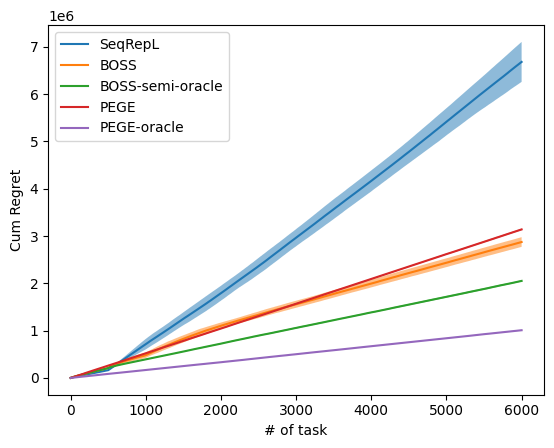

In [433]:
plot_prev_data = True
if plot_prev_data:
    mean_PEGE2, std_PEGE2, mean_PEGE_oracle2, std_PEGE_oracle2, mean_PMA2, std_PMA2, mean_PMA_no_oracle2, std_PMA_no_oracle2, mean_SeqRepL2, std_SeqRepL2 = load_dict('NoTaskDiv_RegExp.npy')
else:
    mean_PEGE2 = np.mean(best_PEGE2['regrets'], axis=0)
    std_PEGE2 = np.std(best_PEGE2['regrets'], axis=0)
    mean_PEGE_oracle2 = np.mean(best_PEGE_oracle2['regrets'], axis=0)
    std_PEGE_oracle2 = np.std(best_PEGE_oracle2['regrets'], axis=0)
    mean_PMA2 = np.mean(best_PMA2['regrets'], axis=0)
    std_PMA2 = np.std(best_PMA2['regrets'], axis=0)
    mean_PMA_no_oracle2 = np.mean(best_PMA_no_oracle2['regrets'], axis=0)
    std_PMA_no_oracle2 = np.std(best_PMA_no_oracle2['regrets'], axis=0)
    mean_SeqRepL2 = np.mean(best_SeqRepL2['regrets'], axis=0)
    std_SeqRepL2 = np.std(best_SeqRepL2['regrets'], axis=0)
X = np.arange(1,n_task+1)
plt.plot(X, mean_SeqRepL2, '-', label='SeqRepL')
plt.fill_between(X, mean_SeqRepL2-std_SeqRepL2, mean_SeqRepL2+std_SeqRepL2, alpha=0.5)
plt.plot(X, mean_PMA_no_oracle2, '-', label='BOSS')
plt.fill_between(X, mean_PMA_no_oracle2-std_PMA_no_oracle2, mean_PMA_no_oracle2+std_PMA_no_oracle2, alpha=0.5)
plt.plot(X, mean_PMA2, '-', label='BOSS-semi-oracle')
plt.fill_between(X, mean_PMA2-std_PMA2, mean_PMA2+std_PMA2, alpha=0.5)
plt.plot(X, mean_PEGE2, '-', label='PEGE')
plt.fill_between(X, mean_PEGE2-std_PEGE2, mean_PEGE2+std_PEGE2, alpha=0.5)
plt.plot(X, mean_PEGE_oracle2, '-', label='PEGE-oracle')
plt.fill_between(X, mean_PEGE_oracle2-std_PEGE_oracle2, mean_PEGE_oracle2+std_PEGE_oracle2, alpha=0.5)
plt.xlabel('# of task')
plt.ylabel('Cum Regret')
plt.legend()
plt.show()
plt.close()
# output_dict = {
#     "mean_PEGE2":mean_PEGE2,
#     "std_PEGE2":std_PEGE2,
#     "mean_PEGE_oracle2":mean_PEGE_oracle2,
#     "std_PEGE_oracle2":std_PEGE_oracle2,
#     "mean_PMA2":mean_PMA2,
#     "std_PMA2":std_PMA2,
#     # "mean_PMA_stop_exr2":mean_PMA_stop_exr2,
#     # "std_PMA_stop_exr2":std_PMA_stop_exr2,
#     "mean_PMA_no_oracle2":mean_PMA_no_oracle2,
#     "std_PMA_no_oracle2":std_PMA_no_oracle2,
#     "mean_SeqRepL2":mean_SeqRepL2,
#     "std_SeqRepL2":std_SeqRepL2,
# }
# np.save('NoTaskDiv_RegExp.npy', output_dict) 

<>:23: SyntaxWarning: invalid escape sequence '\h'
<>:23: SyntaxWarning: invalid escape sequence '\h'
/var/folders/pq/3djhrh750zv53df3bfpn596r0000gn/T/ipykernel_64518/3621155344.py:23: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('||\hat(B)_{n, perp}^T B_n||_F')


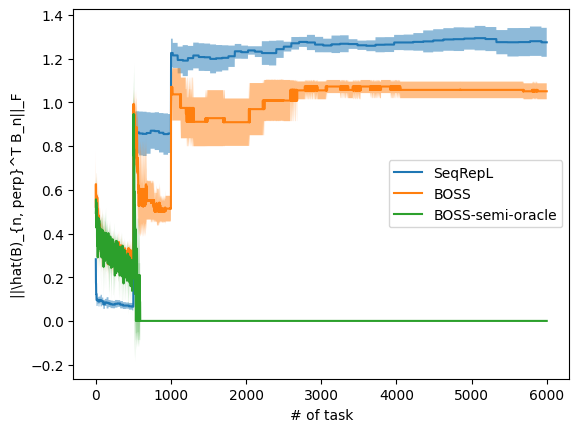

In [436]:
if plot_prev_data:
    mean_PEGE2, std_PEGE2, mean_PEGE_oracle2, std_PEGE_oracle2, mean_PMA2, std_PMA2, mean_PMA_no_oracle2, std_PMA_no_oracle2, mean_SeqRepL2, std_SeqRepL2 = load_dict('NoTaskDiv_B.npy')
else:
    mean_PMA2 = np.mean(best_PMA2['B_hat_err'], axis=0)
    std_PMA2 = np.std(best_PMA2['B_hat_err'], axis=0)
    mean_SeqRepL2 = np.mean(best_SeqRepL2['B_hat_err'], axis=0)
    std_SeqRepL2 = np.std(best_SeqRepL2['B_hat_err'], axis=0)
    mean_PMA_no_oracle2 = np.mean(best_PMA_no_oracle2['B_hat_err'], axis=0)
    std_PMA_no_oracle2 = np.std(best_PMA_no_oracle2['B_hat_err'], axis=0)

X = np.arange(1,n_task+1)
plt.plot(X, mean_SeqRepL2, '-', label='SeqRepL')
plt.fill_between(X, mean_SeqRepL2-std_SeqRepL2, mean_SeqRepL2+std_SeqRepL2, alpha=0.5)
plt.plot(X, mean_PMA_no_oracle2, '-', label='BOSS')
plt.fill_between(X, mean_PMA_no_oracle2-std_PMA_no_oracle2, mean_PMA_no_oracle2+std_PMA_no_oracle2, alpha=0.5)
plt.plot(X, mean_PMA2, '-', label='BOSS-semi-oracle')
plt.fill_between(X, mean_PMA2-std_PMA2, mean_PMA2+std_PMA2, alpha=0.5)
plt.xlabel('# of task')
plt.ylabel('||\hat(B)_{n, perp}^T B_n||_F')
plt.legend()
plt.show()
plt.close()
# output_dict = {
#     "mean_PMA2":mean_PMA2,
#     "std_PMA2":std_PMA2,
#     "mean_PMA_no_oracle2":mean_PMA_no_oracle2,
#     "std_PMA_no_oracle2":std_PMA_no_oracle2,
#     "mean_SeqRepL2":mean_SeqRepL2,
#     "std_SeqRepL2":std_SeqRepL2,
# }
# np.save('NoTaskDiv_B.npy', output_dict) 

<>:21: SyntaxWarning: invalid escape sequence '\h'
<>:21: SyntaxWarning: invalid escape sequence '\h'
/var/folders/pq/3djhrh750zv53df3bfpn596r0000gn/T/ipykernel_64518/3645385776.py:21: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('||\hat{theta}_n - theta_n||_2')


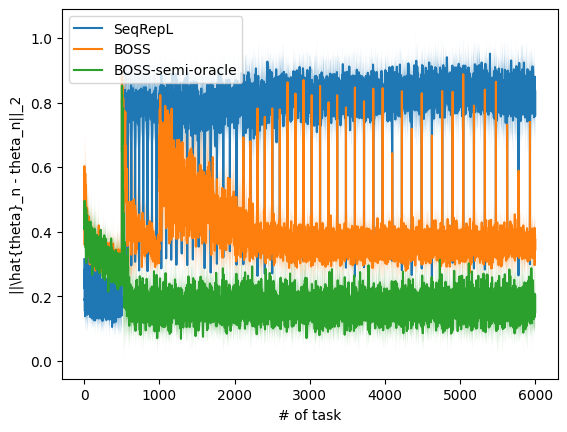

In [437]:
if plot_prev_data:
    mean_PEGE2, std_PEGE2, mean_PEGE_oracle2, std_PEGE_oracle2, mean_PMA2, std_PMA2, mean_PMA_no_oracle2, std_PMA_no_oracle2, mean_SeqRepL2, std_SeqRepL2 = load_dict('NoTaskDiv_theta.npy')
else:
    mean_PMA2 = np.mean(best_PMA2['theta_hat_err'], axis=0)
    std_PMA2 = np.std(best_PMA2['theta_hat_err'], axis=0)
    mean_SeqRepL2 = np.mean(best_SeqRepL2['theta_hat_err'], axis=0)
    std_SeqRepL2 = np.std(best_SeqRepL2['theta_hat_err'], axis=0)
    mean_PMA_no_oracle2 = np.mean(best_PMA_no_oracle2['theta_hat_err'], axis=0)
    std_PMA_no_oracle2 = np.std(best_PMA_no_oracle2['theta_hat_err'], axis=0)

X = np.arange(1,n_task+1)
plt.plot(X, mean_SeqRepL2, '-', label='SeqRepL')
plt.fill_between(X, mean_SeqRepL2-std_SeqRepL2, mean_SeqRepL2+std_SeqRepL2, alpha=0.5)
plt.plot(X, mean_PMA_no_oracle2, '-', label='BOSS')
plt.fill_between(X, mean_PMA_no_oracle2-std_PMA_no_oracle2, mean_PMA_no_oracle2+std_PMA_no_oracle2, alpha=0.5)
plt.plot(X, mean_PMA2, '-', label='BOSS-semi-oracle')
plt.fill_between(X, mean_PMA2-std_PMA2, mean_PMA2+std_PMA2, alpha=0.5)
plt.xlabel('# of task')
plt.ylabel('||\hat{theta}_n - theta_n||_2')
plt.legend()
plt.show()
# plt.close()
# output_dict = {
#     "mean_PMA2":mean_PMA2,
#     "std_PMA2":std_PMA2,
#     "mean_PMA_no_oracle2":mean_PMA_no_oracle2,
#     "std_PMA_no_oracle2":std_PMA_no_oracle2,
#     "mean_SeqRepL2":mean_SeqRepL2,
#     "std_SeqRepL2":std_SeqRepL2,
# }
# np.save('NoTaskDiv_theta.npy', output_dict) 

<>:19: SyntaxWarning: invalid escape sequence '\h'
<>:19: SyntaxWarning: invalid escape sequence '\h'
/var/folders/pq/3djhrh750zv53df3bfpn596r0000gn/T/ipykernel_64518/1300353887.py:19: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('||\hat{theta}_n - theta_n||_2')


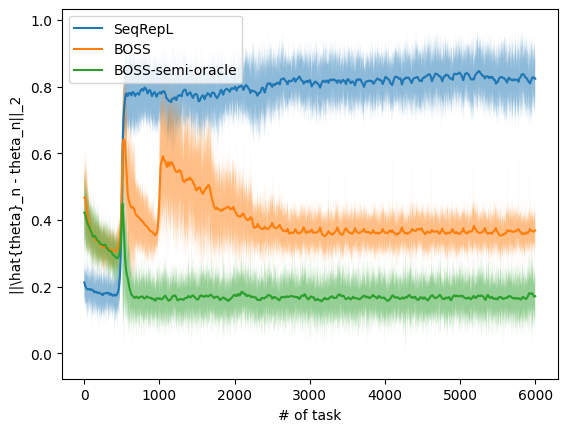

In [438]:
rbf = Rbf(X, mean_PMA_no_oracle2, function = 'multiquadric', smooth = 500)
y_PMA_no_oracle_rbf2 = rbf(X)
rbf = Rbf(X, mean_PMA2, function = 'multiquadric', smooth = 500)
y_PMA_rbf2 = rbf(X)
rbf = Rbf(X, mean_SeqRepL2, function = 'multiquadric', smooth = 500)
y_SeqRepL_rbf2 = rbf(X)

plt.plot(X, y_SeqRepL_rbf2, '-', label='SeqRepL')
plt.fill_between(X, y_SeqRepL_rbf2-std_SeqRepL2, y_SeqRepL_rbf2+std_SeqRepL2, alpha=0.5)
plt.plot(X, y_PMA_no_oracle_rbf2, '-', label='BOSS')
plt.fill_between(X, y_PMA_no_oracle_rbf2-std_PMA_no_oracle2, y_PMA_no_oracle_rbf2+std_PMA_no_oracle2, alpha=0.5)
plt.plot(X, y_PMA_rbf2, '-', label='BOSS-semi-oracle')
plt.fill_between(X, y_PMA_rbf2-std_PMA2, y_PMA_rbf2+std_PMA2, alpha=0.5)
plt.xlabel('# of task')
plt.ylabel('||\hat{theta}_n - theta_n||_2')

plt.legend()
plt.show()

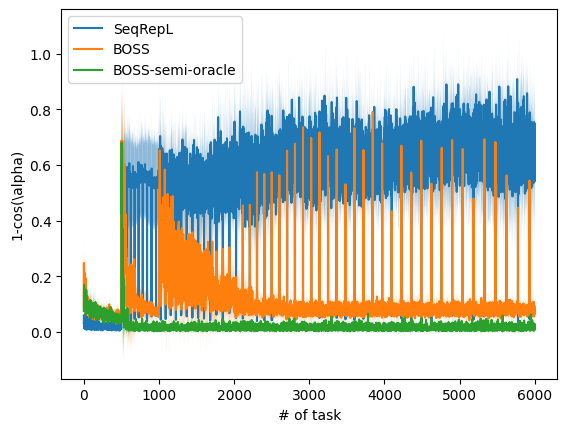

In [439]:
if plot_prev_data:
    mean_PEGE2, std_PEGE2, mean_PEGE_oracle2, std_PEGE_oracle2, mean_PMA2, std_PMA2, mean_PMA_no_oracle2, std_PMA_no_oracle2, mean_SeqRepL2, std_SeqRepL2 = load_dict('NoTaskDiv_angle.npy')
else:
    mean_PMA2 = np.mean(best_PMA2['angle_err'], axis=0)
    std_PMA2 = np.std(best_PMA2['angle_err'], axis=0)
    mean_SeqRepL2 = np.mean(best_SeqRepL2['angle_err'], axis=0)
    std_SeqRepL2 = np.std(best_SeqRepL2['angle_err'], axis=0)
    mean_PMA_no_oracle2 = np.mean(best_PMA_no_oracle2['angle_err'], axis=0)
    std_PMA_no_oracle2 = np.std(best_PMA_no_oracle2['angle_err'], axis=0)

X = np.arange(1,n_task+1)
plt.plot(X, mean_SeqRepL2, '-', label='SeqRepL')
plt.fill_between(X, mean_SeqRepL2-std_SeqRepL2, mean_SeqRepL2+std_SeqRepL2, alpha=0.5)
plt.plot(X, mean_PMA_no_oracle2, '-', label='BOSS')
plt.fill_between(X, mean_PMA_no_oracle2-std_PMA_no_oracle2, mean_PMA_no_oracle2+std_PMA_no_oracle2, alpha=0.5)
plt.plot(X, mean_PMA2, '-', label='BOSS-semi-oracle')
plt.fill_between(X, mean_PMA2-std_PMA2, mean_PMA2+std_PMA2, alpha=0.5)
plt.xlabel('# of task')
plt.ylabel('1-cos(\\alpha)')
plt.legend()
plt.show()
# plt.close()
# output_dict = {
#     "mean_PMA2":mean_PMA2,
#     "std_PMA2":std_PMA2,
#     "mean_PMA_no_oracle2":mean_PMA_no_oracle2,
#     "std_PMA_no_oracle2":std_PMA_no_oracle2,
#     "mean_SeqRepL2":mean_SeqRepL2,
#     "std_SeqRepL2":std_SeqRepL2,
# }
# np.save('NoTaskDiv_angle.npy', output_dict) 

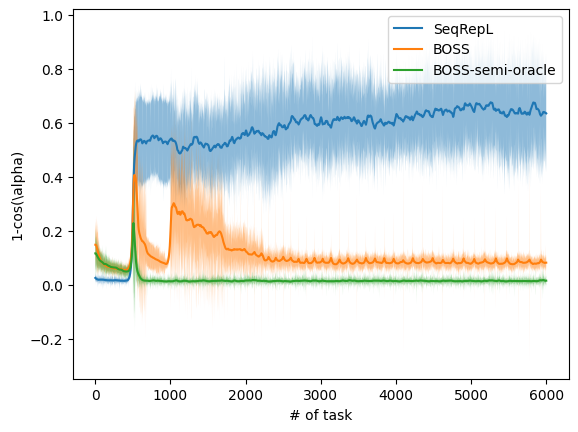

In [440]:
rbf = Rbf(X, mean_PMA_no_oracle2, function = 'multiquadric', smooth = 500)
y_PMA_no_oracle_rbf2 = rbf(X)
rbf = Rbf(X, mean_PMA2, function = 'multiquadric', smooth = 500)
y_PMA_rbf2 = rbf(X)
rbf = Rbf(X, mean_SeqRepL2, function = 'multiquadric', smooth = 500)
y_SeqRepL_rbf2 = rbf(X)

plt.plot(X, y_SeqRepL_rbf2, '-', label='SeqRepL')
plt.fill_between(X, y_SeqRepL_rbf2-std_SeqRepL2, y_SeqRepL_rbf2+std_SeqRepL2, alpha=0.5)
plt.plot(X, y_PMA_no_oracle_rbf2, '-', label='BOSS')
plt.fill_between(X, y_PMA_no_oracle_rbf2-std_PMA_no_oracle2, y_PMA_no_oracle_rbf2+std_PMA_no_oracle2, alpha=0.5)
plt.plot(X, y_PMA_rbf2, '-', label='BOSS-semi-oracle')
plt.fill_between(X, y_PMA_rbf2-std_PMA2, y_PMA_rbf2+std_PMA2, alpha=0.5)
plt.xlabel('# of task')
plt.ylabel('1-cos(\\alpha)')

plt.legend()
plt.show()

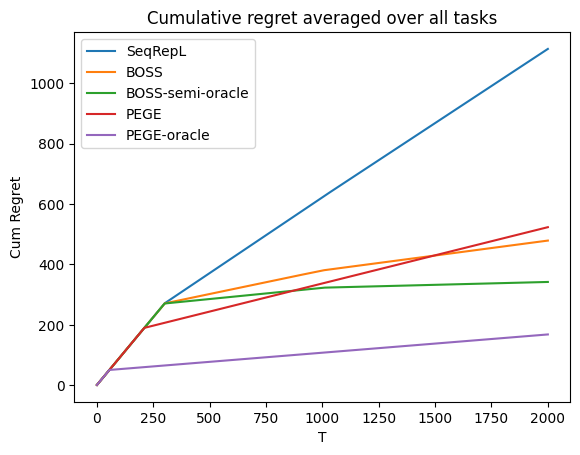

In [441]:
if plot_prev_data:
    mean_PEGE2_in_T, std_PEGE2_in_T, mean_PEGE_oracle2_in_T, std_PEGE_oracle2_in_T, mean_PMA2_in_T, std_PMA2_in_T, mean_PMA_no_oracle2_in_T, std_PMA_no_oracle2_in_T, mean_SeqRepL2_in_T, std_SeqRepL2_in_T = load_dict('NoTaskDiv_T.npy')
else:
    mean_PEGE2_in_T = np.mean(best_PEGE2['regrets_all'], axis=(0,-1))
    std_PEGE2_in_T = np.std(best_PEGE2['regrets_all'], axis=(0,-1))
    mean_PEGE_oracle2_in_T = np.mean(best_PEGE_oracle2['regrets_all'], axis=(0,-1))
    std_PEGE_oracle2_in_T = np.std(best_PEGE_oracle2['regrets_all'], axis=(0,-1))
    mean_PMA2_in_T = np.mean(best_PMA2['regrets_all'], axis=(0,-1))
    std_PMA2_in_T = np.std(best_PMA2['regrets_all'], axis=(0,-1))
    mean_PMA_no_oracle2_in_T = np.mean(best_PMA_no_oracle2['regrets_all'], axis=(0,-1))
    std_PMA_no_oracle2_in_T = np.std(best_PMA_no_oracle2['regrets_all'], axis=(0,-1))
    mean_SeqRepL2_in_T = np.mean(best_SeqRepL2['regrets_all'], axis=(0,-1))
    std_SeqRepL2_in_T = np.std(best_SeqRepL2['regrets_all'], axis=(0,-1))

X = np.arange(1,T+1)
plt.plot(X, mean_SeqRepL2_in_T, '-', label='SeqRepL')
plt.plot(X, mean_PMA_no_oracle2_in_T, '-', label='BOSS')
plt.plot(X, mean_PMA2_in_T, '-', label='BOSS-semi-oracle')
plt.plot(X, mean_PEGE2_in_T, '-', label='PEGE')
plt.plot(X, mean_PEGE_oracle2_in_T, '-', label='PEGE-oracle')
# plt.fill_between(X, mean_SeqRepL2_in_T-std_SeqRepL2_in_T, mean_SeqRepL2_in_T+std_SeqRepL2_in_T, alpha=0.5)
# plt.fill_between(X, mean_PMA_no_oracle2_in_T-std_PMA_no_oracle2_in_T, mean_PMA_no_oracle2_in_T+std_PMA_no_oracle2_in_T, alpha=0.5)
# plt.fill_between(X, mean_PMA2_in_T-std_PMA2_in_T, mean_PMA2_in_T+std_PMA2_in_T, alpha=0.5)
# plt.fill_between(X, mean_PEGE2_in_T-std_PEGE2_in_T, mean_PEGE2_in_T+std_PEGE2_in_T, alpha=0.5)
# plt.fill_between(X, mean_PEGE_oracle2_in_T-std_PEGE_oracle2_in_T, mean_PEGE_oracle2_in_T+std_PEGE_oracle2_in_T, alpha=0.5)
plt.xlabel('T')
plt.ylabel('Cum Regret')
plt.legend()
plt.title(f'Cumulative regret averaged over all tasks')
plt.show()
# plt.close()
# output_dict = {
#     "mean_PEGE2":mean_PEGE2_in_T,
#     "std_PEGE2":std_PEGE2_in_T,
#     "mean_PEGE_oracle2":mean_PEGE_oracle2_in_T,
#     "std_PEGE_oracle2":std_PEGE_oracle2_in_T,
#     "mean_PMA2":mean_PMA2_in_T,
#     "std_PMA2":std_PMA2_in_T,
#     "mean_PMA_no_oracle2":mean_PMA_no_oracle2_in_T,
#     "std_PMA_no_oracle2":std_PMA_no_oracle2_in_T,
#     "mean_SeqRepL2":mean_SeqRepL2_in_T,
#     "std_SeqRepL2":std_SeqRepL2_in_T,
# }
# np.save('NoTaskDiv_T.npy', output_dict) 